# Predicting Diabetes Patient Readmission
Sheng Weng

# Background
It was reported that in 2011 more than 3.3 million patients were readmitted in the US within 30 days of being discharged, and they were associated with about $41 billion in hospital costs. The need for readmission indicates that inadequate care was provided to the patient at the time of first admission. The readmission rate has become an important metric measuring the overall quality of a hospital.

Diabetes is the 7th leading cause of death and affects about 23.6 million people in the US. 1.4 million Americans are diagnosed with diabetes every year. Hospital readmission being a major concern in diabetes care, over 250 million dollars was spent on treatment of readmitted diabetic patients in 2011. Early identification of patients facing a high risk of readmission can enable healthcare providers to conduct additional investigations and possibly prevent future readmissions.

In this project, I build a machine learning classifier model to predict diabetes patients with high risk of readmission. Note that higher sensitivity (recall) is more desirable for hospitals because it is more crucial to correctly identify "high risk" patients who are likely to be readmitted than identifying "low risk" patients.

# Dataset Description
The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes 50 features representing 101766 diabetes patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria:

- It is an inpatient encounter (a hospital admission).
- It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
- The length of stay was at least 1 day and at most 14 days.
- Laboratory tests were performed during the encounter.
- Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

Source: UCI Machine Learning Repository, https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008 



### Overview of Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the file and create a pandas dataframe
data = pd.read_csv('diabetic_data.csv')

In [3]:
# check the dimensions of the data
data.shape

(101766, 50)

In [4]:
# take a first look at the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [5]:
# first 5 rows of data
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### The Response Variable: 'readmitted'

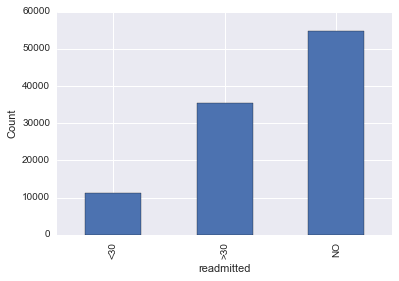

In [6]:
# the response variable 'readmitted' in the original dataset contains three categories.
# 11% of patients were readmitted within 30 days (<30)
# 35% of patients were readmitted after 30 days (>30)
# 54% of patients were never readmitted (NO)
data.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

In [7]:
# recode the response variable so that it becomes a binary classification task.
# '0' means no readmission
# '1' means readmission no matter how many days after being discharged
data['readmitted'] = pd.Series([0 if val == 'NO' else 1 for val in data['readmitted']])

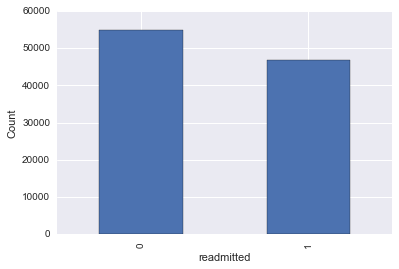

In [8]:
# plot 'readmitted' again to see the change
data.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')

# Feature Engineering and EDA
Explore data analysis on each feature and decide how to deal with them.

In [9]:
# remove unrelavant features
data.drop(['encounter_id', 'patient_nbr', 'payer_code'], axis=1, inplace=True)

In [10]:
# check NA in 'weight'
data[data['weight'] == '?'].shape[0] * 1.0 / data.shape[0]

0.9685847925633315

In [11]:
# check NA in 'medical_specialty'
data[data['medical_specialty'] == '?'].shape[0] * 1.0 / data.shape[0]

0.49082208203132677

In [12]:
# remove 'weight' and 'medical_specialty' because it's hard to do imputation on them
data.drop(['weight', 'medical_specialty'], axis=1, inplace=True)

In [13]:
# remove rows that have NA in 'race', 'diag_1', 'diag_2', or 'diag_3'
# remove rows that have invalid values in 'gender'
data = data[data['race'] != '?']
data = data[data['diag_1'] != '?']
data = data[data['diag_2'] != '?']
data = data[data['diag_3'] != '?']
data = data[data['gender'] != 'Unknown/Invalid']

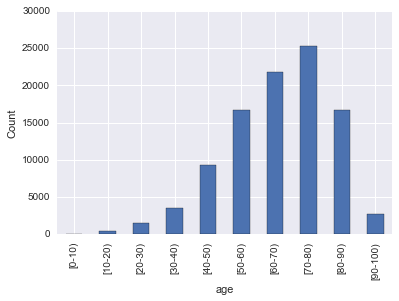

In [14]:
# check 'age' feature
data.groupby('age').size().plot(kind='bar')
plt.ylabel('Count')

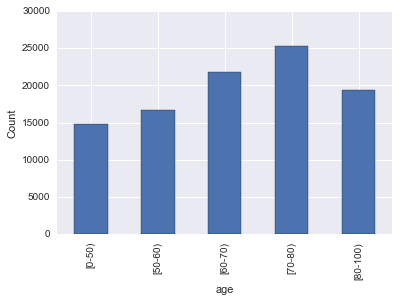

In [15]:
# Recategorize 'age' so that the population is more evenly distributed
data['age'] = pd.Series(['[0-50)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)'] else val 
                         for val in data['age']], index=data.index)
data['age'] = pd.Series(['[80-100)' if val in ['[80-90)', '[90-100)'] else val 
                         for val in data['age']], index=data.index)

data.groupby('age').size().plot(kind='bar')
plt.ylabel('Count')

In [16]:
# original 'discharge_disposition_id' contains 28 levels
# reduce 'discharge_disposition_id' levels into 2 categories
# discharge_disposition_id = 1 corresponds to 'Discharge Home'
data['discharge_disposition_id'] = pd.Series(['Home' if val == 1 else 'Other discharge' 
                                              for val in data['discharge_disposition_id']], index=data.index)

In [17]:
# original 'admission_source_id' contains 25 levels
# reduce 'admission_source_id' into 3 categories
data['admission_source_id'] = pd.Series(['Emergency Room' if val == 7 else 'Referral' if val == 1 else 'Other source' 
                                              for val in data['admission_source_id']], index=data.index)

In [18]:
# original 'admission_type_id' contains 8 levels
# reduce 'admission_type_id' into 2 categories
data['admission_type_id'] = pd.Series(['Emergency' if val == 1 else 'Other type' 
                                       for val in data['admission_type_id']], index=data.index)

23 features represent different medications, should we use them all in the model? 

How to deal with 'diag_1', 'diag_2', and 'diag_3'? 

Based on the results found in Reference[1], we know that:
- The statistical model suggests that the relationship between the probability of readmission and the HbA1c measurement depends on the **primary diagnosis**. 

- The only medication that varied significantly across the patients was the delivery of **insulin**, while other medications remained common among all the patiens.

- It may not be surprising that the attention given to diabetes care in individuals with admitting diagnoses of circulatory or respiratory diseases may have been less than those with a **primary diagnosis of diabetes mellitus**. 

- Greater attention to diabetes care during the hospitalization for these high-risk individuals may have a significant impact on readmission.

- The primary, secondary, and third medical diagnoses are marked by the ICD9 codes. 

- ICD9 code for diabetes: 250.xx

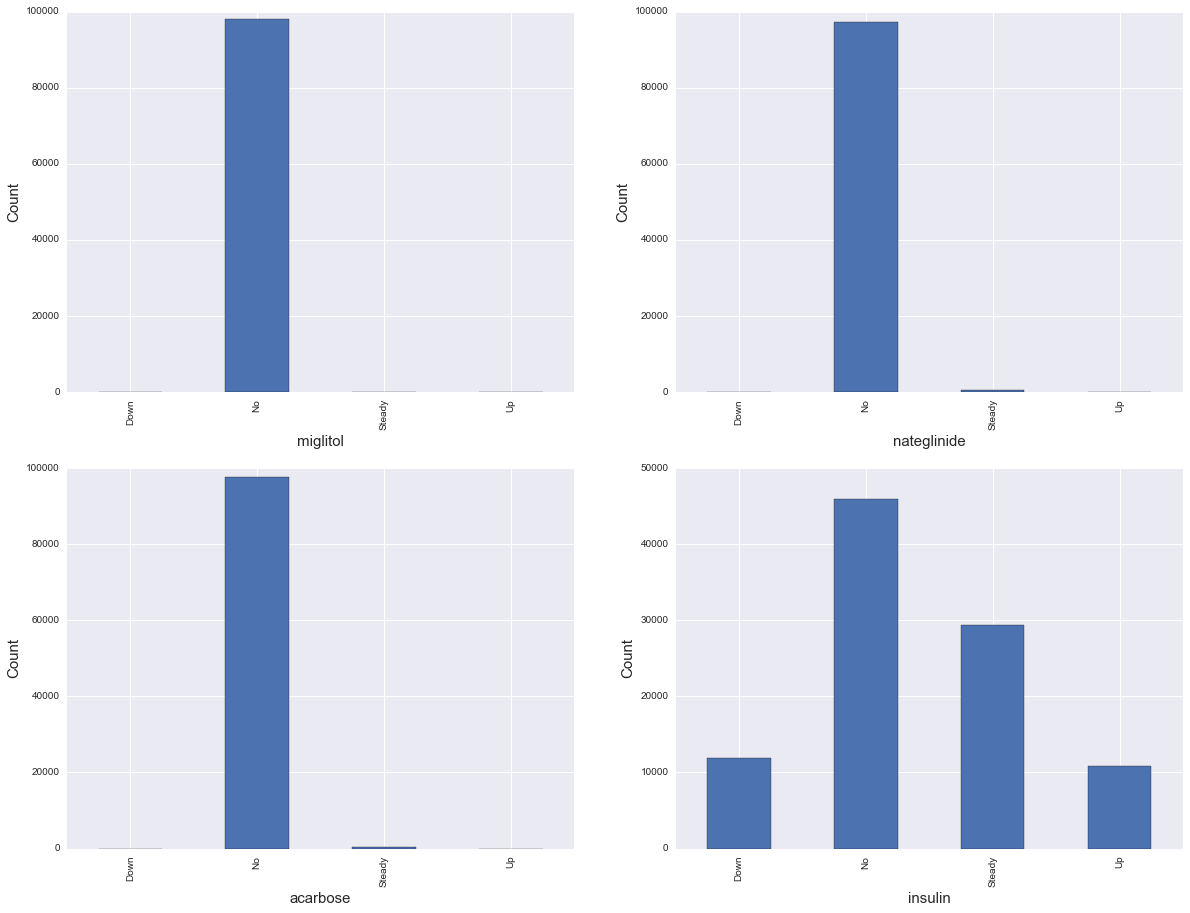

In [19]:
# compare diabetes medications 'miglitol', 'nateglinide' and 'acarbose' with 'insulin', as an example
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(221)
ax1 = data.groupby('miglitol').size().plot(kind='bar')
plt.xlabel('miglitol', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax2 = fig.add_subplot(222)
ax2 = data.groupby('nateglinide').size().plot(kind='bar')
plt.xlabel('nateglinide', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax3 = fig.add_subplot(223)
ax3 = data.groupby('acarbose').size().plot(kind='bar')
plt.xlabel('acarbose', fontsize=15)
plt.ylabel('Count', fontsize=15)

ax4 = fig.add_subplot(224)
ax4 = data.groupby('insulin').size().plot(kind='bar')
plt.xlabel('insulin', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [20]:
# keep only 'insulin' and remove the other 22 diabetes medications
data.drop(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
           'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
           'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 
           'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
           'metformin-rosiglitazone', 'metformin-pioglitazone'], axis=1, inplace=True)

In [21]:
# denote 'diag_1' as '1' if it relates to diabetes and '0' if it's not
# remove 'diag_2' and 'diag_3'
data['diag_1'] = pd.Series([1 if val.startswith('250') else 0 for val in data['diag_1']], index=data.index)
data.drop(['diag_2', 'diag_3'], axis=1, inplace=True)

In [22]:
data.shape

(98052, 21)

In [23]:
# we end up with 98052 rows, 20 features, and one response variable 'readmitted' 
list(data.columns.values)

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'insulin',
 'change',
 'diabetesMed',
 'readmitted']

# Data Preprocessing

In [24]:
# one-hot-encoding on categorical features
# convert nominal values to dummy values
df_age = pd.get_dummies(data['age'])
df_race = pd.get_dummies(data['race'])
df_gender = pd.get_dummies(data['gender'])
df_max_glu_serum = pd.get_dummies(data['max_glu_serum'])
df_A1Cresult = pd.get_dummies(data['A1Cresult'])
df_insulin = pd.get_dummies(data['insulin'])
df_change = pd.get_dummies(data['change'])
df_diabetesMed = pd.get_dummies(data['diabetesMed'])
df_discharge_disposition_id = pd.get_dummies(data['discharge_disposition_id'])
df_admission_source_id = pd.get_dummies(data['admission_source_id'])
df_admission_type_id = pd.get_dummies(data['admission_type_id'])

data = pd.concat([data, df_age, df_race, df_gender, df_max_glu_serum, df_A1Cresult, 
                  df_insulin, df_change, df_diabetesMed, df_discharge_disposition_id, 
                  df_admission_source_id, df_admission_type_id], axis=1)
data.drop(['age', 'race', 'gender', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 
                  'diabetesMed', 'discharge_disposition_id', 'admission_source_id', 
                  'admission_type_id'], axis=1, inplace=True)

In [25]:
# apply square root transformation on right skewed count data to reduce the effects of extreme values.
# here log transformation is not appropriate because the data is Poisson distributed and contains many zero values.
data['number_outpatient'] = data['number_outpatient'].apply(lambda x: np.sqrt(x + 0.5))
data['number_emergency'] = data['number_emergency'].apply(lambda x: np.sqrt(x + 0.5))
data['number_inpatient'] = data['number_inpatient'].apply(lambda x: np.sqrt(x + 0.5))

In [26]:
# feature scaling
feature_scale_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                      'number_diagnoses', 'number_inpatient', 'number_emergency', 'number_outpatient']

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data[feature_scale_cols])
data_scaler = scaler.transform(data[feature_scale_cols])

data_scaler_df = pd.DataFrame(data=data_scaler, columns=feature_scale_cols, index=data.index)
data.drop(feature_scale_cols, axis=1, inplace=True)
data = pd.concat([data, data_scaler_df], axis=1)

# Data Preparation Summary
1. Remove NA in 'race', 'gender', 'diag_1', 'diag_2', and 'diag_3'
2. Remove 29 features in total: 'encounter_id', 'patient_nbr', 'payer_code', 'weight', 'medical_specialty', 'diag_2', 'diag_3', and 22 features for medications, including 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', and 'metformin-pioglitazone'
2. Recategorize 'age' feature
3. Reduce levels in 'discharge_disposition_id', 'admission_source_id', 'admission_type_id'
4. One-hot-encode on categorical data
5. Square root transform on right skewed count data
6. Apply feature scaling on numerical data

# Feature Importance
Evaluate the importance of different features by using emsemble method.

In [27]:
# create X (features) and y (response)
X = data.drop(['readmitted'], axis=1)
y = data['readmitted']

In [28]:
# split X and y into cross-validation (75%) and testing (25%) data sets
from sklearn.cross_validation import train_test_split
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.25)

Top 6 features are: 
num_lab_procedures
num_medications
time_in_hospital
num_procedures
number_inpatient
number_diagnoses


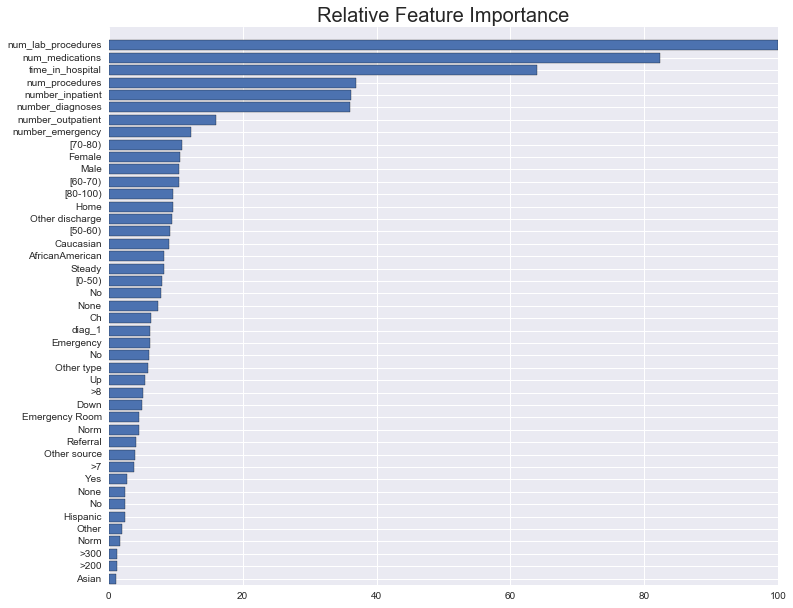

In [29]:
# fit Random Forest model to the data
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_cv, y_cv)
importances = forest.feature_importances_

# make importance relative to the max importance
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
feature_names = list(X_cv.columns.values)
feature_names_sort = [feature_names[indice] for indice in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5
print 'Top 6 features are: '
for feature in feature_names_sort[::-1][:6]:
    print feature

# plot the result
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names_sort)
plt.title('Relative Feature Importance', fontsize=20)
plt.show()

In [30]:
# make a smaller feature set which only contains the top 6 features
X_cv_top6 = X_cv[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses',
           'number_inpatient']]

# Model Selection
Compare the performance of three machine learning classifiers: Random Forest, Naive Bayes, and Logistic Regression.

Select the best model using 10-fold cross validation. The metric that will be using is the accuracy of prediction.

In [31]:
from sklearn.cross_validation import cross_val_score

In [32]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier()
RF_score = cross_val_score(clf1, X_cv, y_cv, cv=10, scoring='accuracy').mean()
RF_score

0.58593379411213009

In [33]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
NB_score = cross_val_score(clf2, X_cv, y_cv, cv=10, scoring='accuracy').mean()
NB_score

0.59989933082603231

In [34]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf3 = LogisticRegression()
LR_score = cross_val_score(clf3, X_cv, y_cv, cv=10, scoring='accuracy').mean()
LR_score

0.61988869843944083

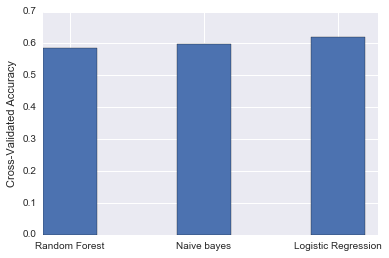

In [35]:
# plot and compare the scores
# LR outperforms the other two a little bit
x_axis = np.arange(3)
y_axis = [RF_score, NB_score, LR_score]
plt.bar(x_axis, y_axis, width=0.4)
plt.xticks(x_axis + 0.4/2., ('Random Forest', 'Naive bayes', 'Logistic Regression'))
plt.ylabel('Cross-Validated Accuracy')

In [36]:
# Logistic Regression on Top 6 features
# still be able to achieve good result with reduced running time
LR_score_top = cross_val_score(clf3, X_cv_top6, y_cv, cv=10, scoring='accuracy').mean()
LR_score_top

0.61266805495612375

# Parameter Tuning Using GridSearchCV
Use GridSearchCV to tune parameter C in logistic regression. Smaller C values specify stronger regularization.

In [37]:
# define the parameter values that should be searched
C_range = np.arange(0.1, 3.1, 0.2)
param_grid = dict(C = C_range)

In [38]:
# instantiate the grid, fit the grid with data
from sklearn.grid_search import GridSearchCV
clf = LogisticRegression()
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(X_cv, y_cv)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,
        2.3,  2.5,  2.7,  2.9])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

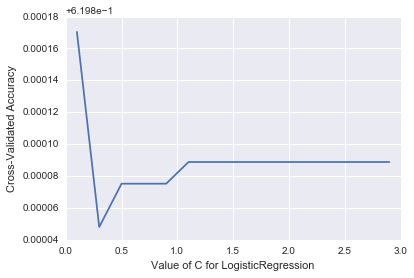

In [39]:
# plot the results
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
plt.plot(C_range, grid_mean_scores)
plt.xlabel('Value of C for LogisticRegression')
plt.ylabel('Cross-Validated Accuracy')

In [40]:
# examine the best model
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.619970355866
{'C': 0.10000000000000001}
LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


# Evaluation Metrics

### Classification accuracy
NULL accuracy: accuracy that could be achieved by always predicting the most frequent class -- 'No Readmission'.

In [41]:
# examine the class distribution of the testing set
y_test.value_counts()

0    12949
1    11564
Name: readmitted, dtype: int64

In [42]:
# calculate null accuracy (for binary classification problems coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.5282503161587728

In [43]:
# train a logistic regression model on the cross-validation set with the optimal C parameter
logreg = LogisticRegression(C=1.1)
logreg.fit(X_cv, y_cv)

LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
# make class predictions for the testing set 
# calculate accuracy and compare with null accuracy
from sklearn import metrics
y_pred_class = logreg.predict(X_test)
print metrics.accuracy_score(y_test, y_pred_class)

0.616407620446


### Confusion matrix
Table that describes the performance of a classification model

*True Positives (TP)*: we correctly predicted that they do have diabetes

*True Negatives (TN)*: we correctly predicted that they don't have diabetes

*False Positives (FP)*: we incorrectly predicted that they do have diabetes (a "Type I error")

*False Negatives (FN)*: we incorrectly predicted that they don't have diabetes (a "Type II error")

In [45]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print confusion

[[10068  2881]
 [ 6522  5042]]


**Sensitivity (Recall)**: How "sensitive" is the classifier to detecting positive instances? TP/(TP+FN)

In [46]:
print metrics.recall_score(y_test, y_pred_class)

0.436008301626


**Specificity**: TN/(TN+FP)

In [47]:
print TN / float(TN + FP)

0.777511776971


**False Positive Rate (1 - specificity)**: FP/(TN+FP)

In [48]:
print FP / float(TN + FP)

0.222488223029


**Precision**: TP/(TP+FP)

In [49]:
print metrics.precision_score(y_test, y_pred_class)

0.636375110438


**F1 score**: F1 = 2 x precision x recall / (precision + recall)

In [50]:
print metrics.f1_score(y_test, y_pred_class)

0.517473187253


### Receiver operating characteristic (ROC) curve and area under the curve (AUC)
ROC is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. AUC is the percentage of the ROC plot that is underneath the curve. AUC is useful as a single number summary of classifier performance.

In [51]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

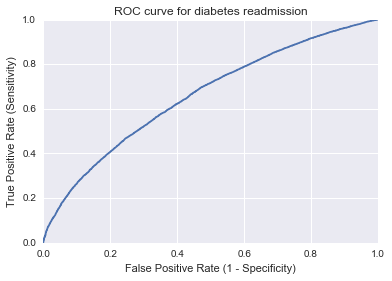

In [52]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes readmission')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [53]:
# AUC score
print metrics.roc_auc_score(y_test, y_pred_prob)

0.659604982792


### Adjusting the classification threshold

Decrease the threshold to increase the sensitivity of the classifier, which is more favorable to the prediction of diabetes patients readmission.

In [54]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print 'Sensitivity:', tpr[thresholds > threshold][-1]
    print 'Specificity:', 1 - fpr[thresholds > threshold][-1]

In [55]:
# predict readmission if the predicted probability is greater than 0.41
# the resulting sensitivity can achieve above 0.70
evaluate_threshold(0.41)

Sensitivity: 0.699152542373
Specificity: 0.523747007491


# Conclusions
- Six major features are found to have high impact on diabetes patients readmission: number of lab procedures, number of medications administrated during the encounter, time spent in hospital, number of procedures other than lab tests,  number of diagnoses, and number of inpatient visits.

- The logistic regression classifier modeling achieves 0.62 accuracy and 0.67 AUC score. The sensitivity of the modeling can be increased by adjusting the classification threshold.

- To correctly predict the readmission and avoid extra cost, hospitals should carefully examine the clinical data of patients and pay special attention to the above features.

- Some other features might be worth collecting, for example, date of admission and family history.

- This analytic method can be applied to different diseases other than diabetes.

# References
1. Strack, Beata, et al. "Impact of HbA1c measurement on hospital readmission rates: analysis of 70,000 clinical database patient records." BioMed research international 2014 (2014).
2. Bhuvan, Malladihalli S., et al. "Identifying Diabetic Patients with High Risk of Readmission." arXiv preprint arXiv:1602.04257 (2016).
3. Sushmita, Shanu, et al. "Predicting 30-Day Risk and Cost of" All-Cause" Hospital Readmissions." Workshops at the Thirtieth AAAI Conference on Artificial Intelligence. 2016.